In [1]:
from pandas_profiling import ProfileReport
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import os
import time
import datetime
import urllib.request
import pytz

import scipy.stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
sns.set_theme(style="darkgrid")

In [3]:
#file downloading function 

def to_date_str(date_arr):
    year = str(date_arr[0])
    month = ('0' + str(date_arr[1]))[-2:]
    return year + '/' + month

def add_month(date_str):
    date_arr = [int(i) for i in date_str.split('/')]
    if date_arr[1] != 12:
        date_arr[1] += 1
    else:
        date_arr[1] = 1
        date_arr[0] += 1
    return to_date_str(date_arr)

def download_file(download_url, filename):
    response = urllib.request.urlopen(download_url)    
    file = open(filename, 'wb')
    file.write(response.read())
    file.close()

In [4]:
# create seasone column function 
def season(ser):
    for k in seasons.keys():
        if ser in k:
            return seasons[k]

In [5]:
# fill next few rows with actual info
# by defalut, will be downloaded for Oslo, all existing data (since 2019-04 till 2022-06) into folder ./data.
city_name = 'oslo'        # можливі варіанти: olso, bergen, trondheim

start_month = 4           # 1 - 12
start_year = 2019         # 2019 - 2022

end_month = 6             # 1 - 12
end_year = 2022           # 2019 - 2022

destination_folder = '/Users/chedmurray/Desktop/безіменна папка 2'

In [6]:

# generate all possible month-year combinations within the selected period
cur_date_str = to_date_str([start_year, start_month])
end_date_str = to_date_str([end_year, end_month])
dates_str_list = list()
if cur_date_str == end_date_str:
    dates_str_list = [cur_date_str]
else:
    while True:
        dates_str_list.append(cur_date_str)
        cur_date_str = add_month(cur_date_str)
        if cur_date_str == end_date_str:
            dates_str_list.append(cur_date_str)
            break

In [7]:
# download files
start = time.time()
if os.path.exists(destination_folder):
    for date in dates_str_list:
        download_url = f"https://data.urbansharing.com/{city_name}bysykkel.no/trips/v1/{date}.csv"
        filename = f"{city_name}_{date.replace('/', '_')}.csv"
        print("in progres: ", filename[:-4])
        destination_full_path = '/'.join([destination_folder, filename])
        download_file(download_url, destination_full_path)
else:
    print("Destination folder not found")
end = time.time()
print('Time: ', end - start, ' s')

in progres:  oslo_2019_04
in progres:  oslo_2019_05
in progres:  oslo_2019_06
in progres:  oslo_2019_07
in progres:  oslo_2019_08
in progres:  oslo_2019_09
in progres:  oslo_2019_10
in progres:  oslo_2019_11
in progres:  oslo_2019_12
in progres:  oslo_2020_01
in progres:  oslo_2020_02
in progres:  oslo_2020_03
in progres:  oslo_2020_04
in progres:  oslo_2020_05
in progres:  oslo_2020_06
in progres:  oslo_2020_07
in progres:  oslo_2020_08
in progres:  oslo_2020_09
in progres:  oslo_2020_10
in progres:  oslo_2020_11
in progres:  oslo_2020_12
in progres:  oslo_2021_01
in progres:  oslo_2021_02
in progres:  oslo_2021_03
in progres:  oslo_2021_04
in progres:  oslo_2021_05
in progres:  oslo_2021_06
in progres:  oslo_2021_07
in progres:  oslo_2021_08
in progres:  oslo_2021_09
in progres:  oslo_2021_10
in progres:  oslo_2021_11
in progres:  oslo_2021_12
in progres:  oslo_2022_01
in progres:  oslo_2022_02
in progres:  oslo_2022_03
in progres:  oslo_2022_04
in progres:  oslo_2022_05
in progres: 

In [8]:
os.chdir("/Users/chedmurray/Desktop/безіменна папка 2") # определение рабочей дериктории 
csv = !ls

dataframes = (pd.read_csv(f) for f in csv)
df = pd.concat(dataframes, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910846 entries, 0 to 5910845
Data columns (total 13 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   started_at                 object 
 1   ended_at                   object 
 2   duration                   object 
 3   start_station_id           object 
 4   start_station_name         object 
 5   start_station_description  object 
 6   start_station_latitude     float64
 7   start_station_longitude    float64
 8   end_station_id             object 
 9   end_station_name           object 
 10  end_station_description    object 
 11  end_station_latitude       float64
 12  end_station_longitude      float64
dtypes: float64(4), object(9)
memory usage: 586.3+ MB


In [9]:
station_name = pd.read_csv('https://media.githubusercontent.com/media/oyakymchuk/project_bysykkel/master/data/oslo_stations.csv')

In [10]:
# data transformation

# new timzone 
strptime_pattern = "%Y-%m-%d %H:%M:%S%z"
timezone = pytz.timezone('Europe/Oslo')

start = time.time()
df['started_at_dt'] = df['started_at'].apply(lambda x: datetime.datetime.strptime(x[:-6].split('.')[0] + x[-6:], strptime_pattern).astimezone(timezone))
df['ended_at_dt'] = df['ended_at'].apply(lambda x: datetime.datetime.strptime(x[:-6].split('.')[0] + x[-6:], strptime_pattern).astimezone(timezone))

#station names 

df = df.merge(station_name[['station_id','station_name']], 
        left_on='start_station_id',right_on='station_id').merge(station_name[['station_id','station_name']], 
        left_on='end_station_id',right_on='station_id', 
        suffixes=('_start', '_end'))

#add new columns 

df['day_of_week'] = df['started_at_dt'].dt.day_name()
df['month']=df['started_at_dt'].map(lambda x:x.month)
df['year']=df['started_at_dt'].map(lambda x:x.year)
df['hour']=df['started_at_dt'].map(lambda x:x.hour)
df['hour_fin']=df['ended_at_dt'].map(lambda x:x.hour)
df['date']=df['started_at_dt'].map(lambda x:x.date())
df['for_count']=1

seasons = {(1, 12, 2): 'winter', (3, 4, 5): 'spring', (6, 7, 8): 'summer', (9, 10, 11): 'autumn'}

def season(ser):
    for k in seasons.keys():
        if ser in k:
            return seasons[k]

df['season'] = df['month'].apply(season)
df['duration'] = df['duration'].astype(int)

df['day_of_week'] = df.day_of_week.astype('category')
df['day_of_week'] = df['day_of_week'].cat.reorder_categories(['Monday', 'Tuesday', 
                                          'Wednesday', 'Thursday', 
                                         'Friday', 'Saturday', 'Sunday'])

df['season'] = df.season.astype('category')
df['season'] = df['season'].cat.reorder_categories(['winter', 'spring', 'summer', 'autumn'])


df.drop(labels=['started_at', 'ended_at', 
               'start_station_name', 'end_station_name', 
                'station_id_start', 'station_id_end'], axis=1, inplace=True)


df.rename(columns={"station_name_start": "start_station_name", 
                   "station_name_end": "end_station_name"}, inplace=True)

end = time.time()

df = df[(df['duration'] <= 60*60*24)]

print("Трансформування: ", end - start, "с.")

Трансформування:  266.94961977005005 с.


In [11]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5910360 entries, 0 to 5910845
Data columns (total 21 columns):
 #   Column                     Dtype                      
---  ------                     -----                      
 0   duration                   int64                      
 1   start_station_id           object                     
 2   start_station_description  object                     
 3   start_station_latitude     float64                    
 4   start_station_longitude    float64                    
 5   end_station_id             object                     
 6   end_station_description    object                     
 7   end_station_latitude       float64                    
 8   end_station_longitude      float64                    
 9   started_at_dt              datetime64[ns, Europe/Oslo]
 10  ended_at_dt                datetime64[ns, Europe/Oslo]
 11  start_station_name         object                     
 12  end_station_name           object         

##  Завдання 2 ## 

In [30]:
# info by station about duration 

by_station_count_and_durationstats = df[['start_station_name', 'duration' ]].groupby(['start_station_name']).agg(
    number_of_trips=('duration', 'count'),
    min_duration=('duration', min),
    max_duration=('duration', max), 
    mean_duration=('duration', np.mean), 
    median_duration=('duration', np.median),
    standard_deviation_duration=('duration', np.std),
    variance_duration=('duration', np.var)).reset_index()

station_by_year_durationstats = df[['start_station_name', 'year', 'duration' ]].groupby(['start_station_name', 'year']).agg(
    number_of_trips=('duration', 'count'),
    min_duration=('duration', min),
    max_duration=('duration', max), 
    mean_duration=('duration', np.mean), 
    median_duration=('duration', np.median),
    standard_deviation_duration=('duration', np.std),
    variance_duration=('duration', np.var)).reset_index()

station_by_season_duration = df[['start_station_name', 'season', 'duration' ]].groupby(['start_station_name', 'season']).agg(
    number_of_trips=('duration', 'count'),
    min_duration=('duration', min),
    max_duration=('duration', max), 
    mean_duration=('duration', np.mean), 
    median_duration=('duration', np.median),
    standard_deviation_duration=('duration', np.std),
    variance_duration=('duration', np.var)).reset_index()

station_by_season_durationstats = df[['start_station_name','year', 'season', 'duration' ]].groupby(['start_station_name', 'year', 'season']).agg(
    number_of_trips=('duration', 'count'),
    min_duration=('duration', min),
    max_duration=('duration', max), 
    mean_duration=('duration', np.mean), 
    median_duration=('duration', np.median),
    standard_deviation_duration=('duration', np.std),
    variance_duration=('duration', np.var)).reset_index()

station_by_month_durationstats = df[['start_station_name', 'month', 'year',  'duration' ]].groupby(['start_station_name', 'month', 'year']).agg(
    number_of_trips=('duration', 'count'),
    min_duration=('duration', min),
    max_duration=('duration', max), 
    mean_duration=('duration', np.mean), 
    median_duration=('duration', np.median),
    standard_deviation_duration=('duration', np.std),
    variance_duration=('duration', np.var)).reset_index()

station_by_day_of_week_durationstats = df[['start_station_name', 'month', 'year', 'day_of_week', 'duration' ]].groupby(['start_station_name', 'day_of_week', 'month', 'year']).agg(
    number_of_trips=('duration', 'count'),
    min_duration=('duration', min),
    max_duration=('duration', max), 
    mean_duration=('duration', np.mean), 
    median_duration=('duration', np.median),
    standard_deviation_duration=('duration', np.std),
    variance_duration=('duration', np.var)).reset_index()

station_by_hour_durationstats = df[['start_station_name', 'hour', 'duration' ]].groupby(['start_station_name', 'hour']).agg(
    number_of_trips=('duration', 'count'),
    min_duration=('duration', min),
    max_duration=('duration', max), 
    mean_duration=('duration', np.mean), 
    median_duration=('duration', np.median),
    standard_deviation_duration=('duration', np.std),
    variance_duration=('duration', np.var)).reset_index()

In [14]:
station_by_year_trips = station_by_year_durationstats[['start_station_name', 
                                                       'number_of_trips' ]].describe().reset_index()

station_by_season = station_by_season_durationstats[['start_station_name', 
                                                     'number_of_trips', 'year' ]].groupby(['start_station_name', 'year']).describe().reset_index()

station_by_month = station_by_month_durationstats[['start_station_name',
                                                   'number_of_trips', 'year' ]].groupby(['start_station_name', 'year']).describe().reset_index()

station_by_day_of_week = station_by_day_of_week_durationstats[['start_station_name', 
                                                               'number_of_trips', 'month', 'year']].groupby(['start_station_name', 'month', 'year']).describe().reset_index()


In [17]:
station_by_month_durationstats

,start_station_name,month,year,number_of_trips,min_duration,max_duration,mean_duration,median_duration,standard_deviation_duration,variance_duration
0,7. juni-plassen,1,2021,116,84,4591,640.844828,486.5,693.259756,4.806091e+05
1,7. juni-plassen,1,2022,41,189,3216,636.073171,464.0,519.951411,2.703495e+05
2,7. juni-plassen,2,2021,131,119,3931,690.122137,550.0,552.982070,3.057892e+05
3,7. juni-plassen,2,2022,102,64,3157,520.931373,434.0,382.566457,1.463571e+05
4,7. juni-plassen,3,2020,167,61,12593,1096.371257,724.0,1502.301116,2.256909e+06
...,...,...,...,...,...,...,...,...,...,...
9365,Økernveien,11,2020,179,77,3137,606.597765,512.0,452.268434,2.045467e+05
9366,Økernveien,11,2021,119,83,5936,606.605042,494.0,648.791200,4.209300e+05
9367,Økernveien,12,2019,23,80,785,397.565217,388.0,194.564508,3.785535e+04
9368,Økernveien,12,2020,103,78,4592,549.786408,422.0,537.004320,2.883736e+05


In [24]:
def station_stats(df):
    """Displays the most popular stations"""

    print('\nCalculating The Most Popular Stations and Trip...\n')
    start_time = time.time()

    # display most commonly used start station
    print("The most commonly used start station is ", df['start_station_name'].mode()[0], "\n")

    # display most commonly used end station
    print("The most commonly used end station is ", df['end_station_name'].mode()[0], "\n")

    
    
def time_stats(df):
    """Displays the most frequent times of travel."""

    print('\nCalculating The Most Frequent Times of Travel...\n')
    start_time = time.time()
    
    # display the most common season
    print("The most common year is ", df['year'].mode()[0], "\n")
    
    # display the most common season
    print("The most common season is ", df['season'].mode()[0], "\n")

    # display the most common month
    print("The most common month is ", df['month'].mode()[0], "\n")

    # display the most common day of week
    print("The most common day of week  is ", df['day_of_week'].mode()[0], "\n")

    # display the most common start hour
    print("The most common start hour is ", df['hour'].mode()[0], "\n")    
    
    # display the most common finish hour
    print("The most common finish hour is ", df['hour_fin'].mode()[0])  

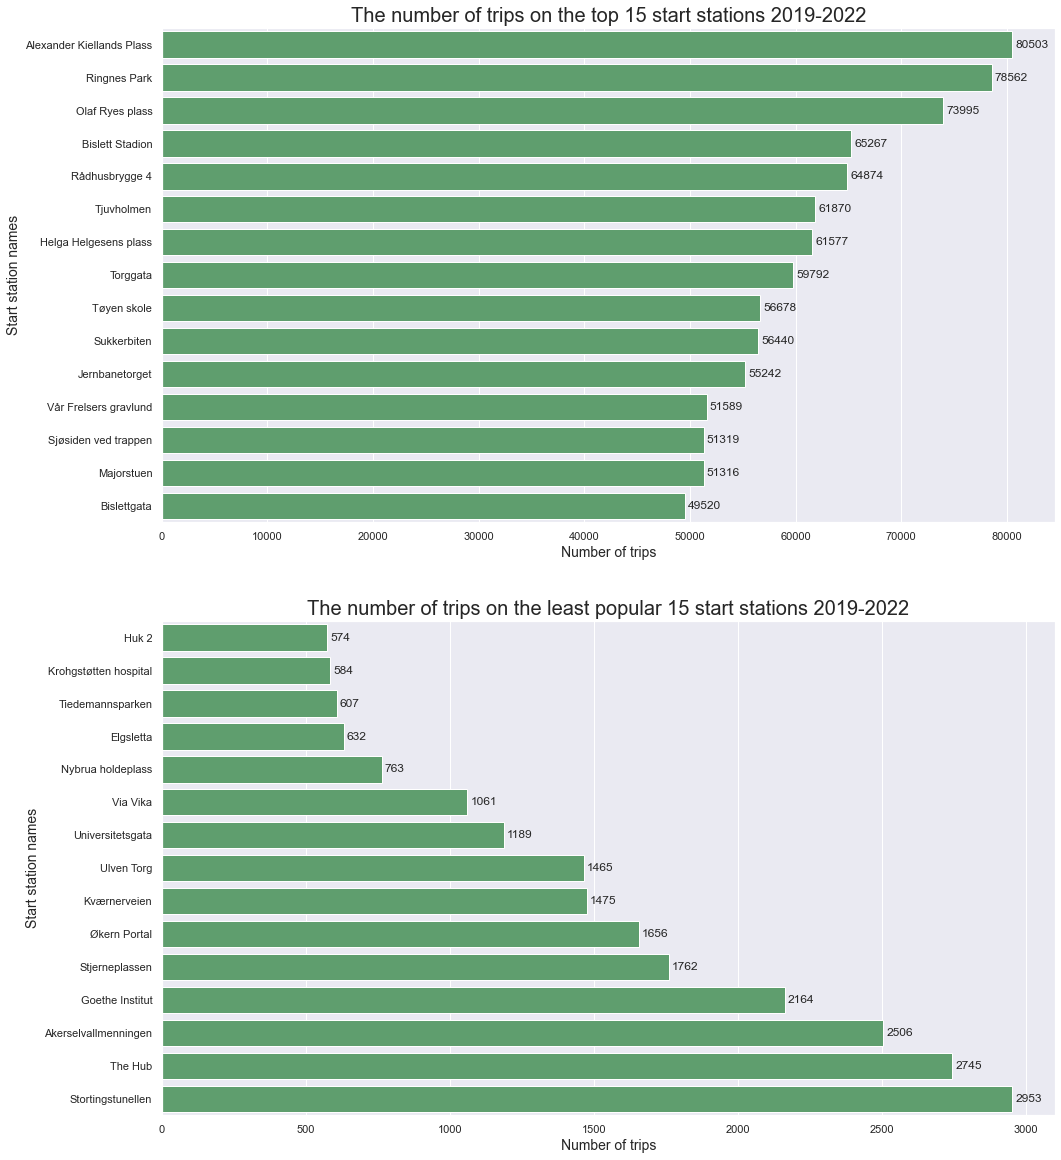

In [25]:
f, (ax1, ax2) = plt.subplots(2, figsize=(16, 20))


ax1 = sns.barplot(data=by_station_count_and_durationstats[['start_station_name',
                          'number_of_trips']].sort_values('number_of_trips', ascending=False).head(15), 
            x='number_of_trips', y='start_station_name',
            color='g', ax=ax1)

ax1.set_ylabel('Start station names', fontsize = 14)
ax1.set_xlabel('Number of trips', fontsize = 14)
ax1.set_title("The number of trips on the top 15 start stations 2019-2022", fontsize = 20)
ax1.bar_label(ax1.containers[0], padding=3)


ax2 = sns.barplot(data=by_station_count_and_durationstats[['start_station_name',
                          'number_of_trips']].sort_values('number_of_trips').head(15), 
            x='number_of_trips', y='start_station_name',
            color='g', ax=ax2)

ax2.set_ylabel('Start station names', fontsize = 14)
ax2.set_xlabel('Number of trips', fontsize = 14)
ax2.set_title("The number of trips on the least popular 15 start stations 2019-2022", fontsize = 20)
ax2.bar_label(ax2.containers[0], padding=3)


plt.show()

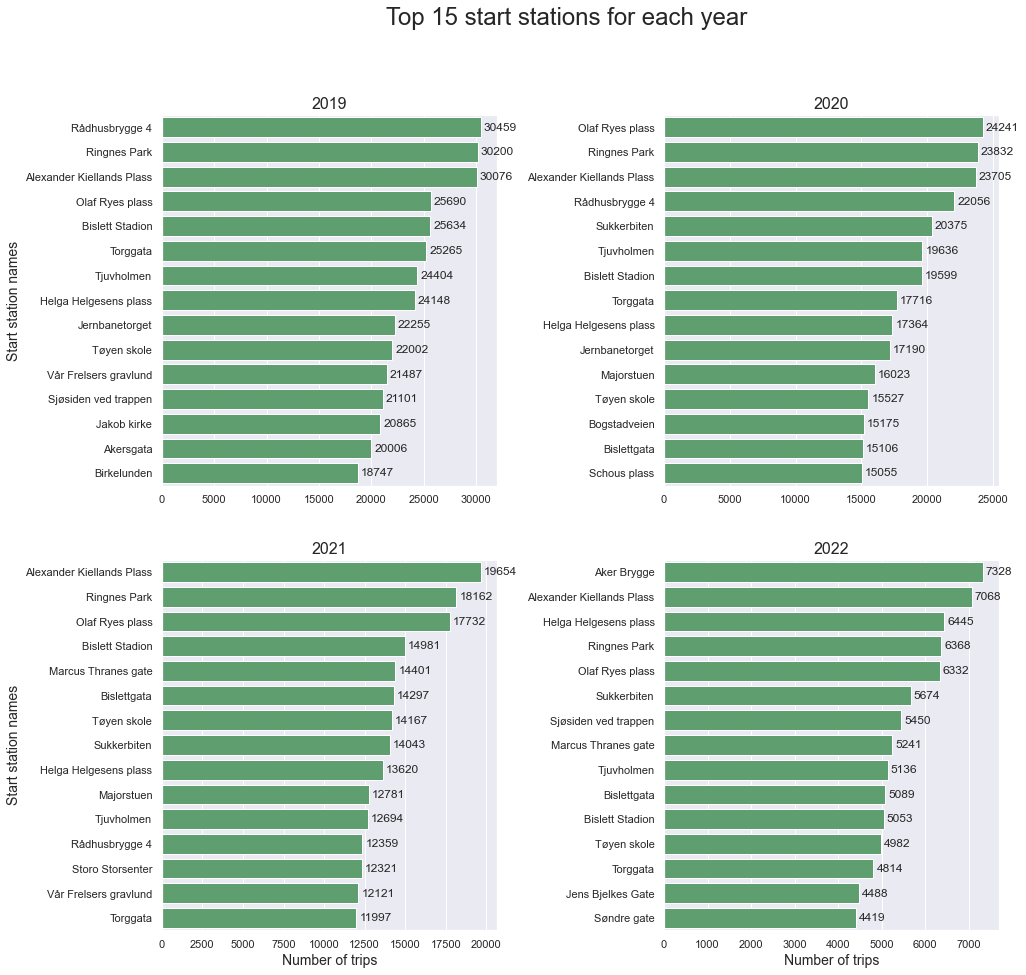

In [26]:
f, axes = plt.subplots(2, 2, figsize=(15, 15))

sns.barplot(data=station_by_year_durationstats.loc[station_by_year_durationstats['year'] == 2019, 
                ['start_station_name','number_of_trips']].sort_values('number_of_trips', ascending=False).head(15),
           x='number_of_trips', y='start_station_name', ax=axes[0, 0], color='g')



axes[0, 0].set_ylabel('Start station names', fontsize = 14)
axes[0, 0].set_xlabel('', fontsize = 14)
axes[0, 0].set_title('2019', fontsize = 16)
axes[0, 0].bar_label(axes[0, 0].containers[0], padding=3)

sns.barplot(data=station_by_year_durationstats.loc[station_by_year_durationstats['year'] == 2020, 
                ['start_station_name','number_of_trips']].sort_values('number_of_trips', ascending=False).head(15),
           x='number_of_trips', y='start_station_name', ax=axes[0, 1], color='g')

axes[0, 1].set_ylabel('', fontsize = 14)
axes[0, 1].set_xlabel('', fontsize = 14)
axes[0, 1].set_title('2020', fontsize = 16)
axes[0, 1].bar_label(axes[0, 1].containers[0], padding=3)


sns.barplot(data=station_by_year_durationstats.loc[station_by_year_durationstats['year'] == 2021, 
                ['start_station_name','number_of_trips']].sort_values('number_of_trips', ascending=False).head(15),
           x='number_of_trips', y='start_station_name', ax=axes[1, 0], color='g')

axes[1, 0].set_ylabel('Start station names', fontsize = 14)
axes[1, 0].set_xlabel('Number of trips', fontsize = 14)
axes[1, 0].set_title('2021', fontsize = 16)
axes[1, 0].bar_label(axes[1, 0].containers[0], padding=3)


sns.barplot(data=station_by_year_durationstats.loc[station_by_year_durationstats['year'] == 2022, 
                ['start_station_name','number_of_trips']].sort_values('number_of_trips', ascending=False).head(15),
           x='number_of_trips', y='start_station_name', ax=axes[1, 1], color='g')

axes[1, 1].set_ylabel('', fontsize = 14)
axes[1, 1].set_xlabel('Number of trips', fontsize = 14)
axes[1, 1].set_title('2022', fontsize = 16)
axes[1, 1].bar_label(axes[1, 1].containers[0], padding=3)

plt.suptitle('Top 15 start stations for each year', fontsize = 24)
plt.subplots_adjust(wspace=0.5)#, 
                   # hspace=0.1)

plt.show()

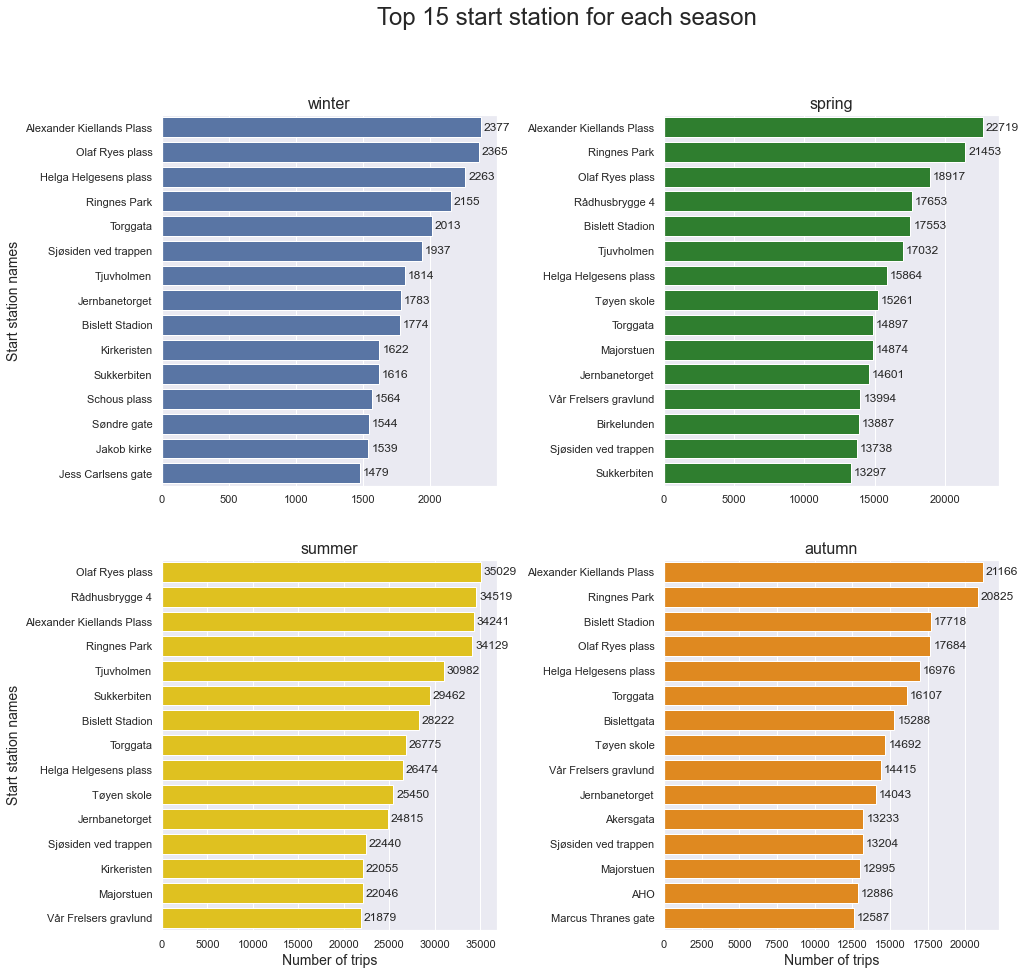

In [31]:
f, axes = plt.subplots(2, 2, figsize=(15, 15))

sns.barplot(data=station_by_season_duration.loc[station_by_season_duration['season'] == 'winter', 
                ['start_station_name','number_of_trips']].sort_values('number_of_trips', ascending=False).head(15),
           x='number_of_trips', y='start_station_name', ax=axes[0, 0], color='b')



axes[0, 0].set_ylabel('Start station names', fontsize = 14)
axes[0, 0].set_xlabel('', fontsize = 14)
axes[0, 0].set_title('winter', fontsize = 16)
axes[0, 0].bar_label(axes[0, 0].containers[0], padding=3)

sns.barplot(data=station_by_season_duration.loc[station_by_season_duration['season'] == 'spring', 
                ['start_station_name','number_of_trips']].sort_values('number_of_trips', ascending=False).head(15),
           x='number_of_trips', y='start_station_name', ax=axes[0, 1], color='forestgreen')

axes[0, 1].set_ylabel('', fontsize = 14)
axes[0, 1].set_xlabel('', fontsize = 14)
axes[0, 1].set_title('spring', fontsize = 16)
axes[0, 1].bar_label(axes[0, 1].containers[0], padding=3)


sns.barplot(data=station_by_season_duration.loc[station_by_season_duration['season'] == 'summer', 
                ['start_station_name','number_of_trips']].sort_values('number_of_trips', ascending=False).head(15),
           x='number_of_trips', y='start_station_name', ax=axes[1, 0], color='gold')

axes[1, 0].set_ylabel('Start station names', fontsize = 14)
axes[1, 0].set_xlabel('Number of trips', fontsize = 14)
axes[1, 0].set_title('summer', fontsize = 16)
axes[1, 0].bar_label(axes[1, 0].containers[0], padding=3)


sns.barplot(data=station_by_season_duration.loc[station_by_season_duration['season'] == 'autumn', 
                ['start_station_name','number_of_trips']].sort_values('number_of_trips', ascending=False).head(15),
           x='number_of_trips', y='start_station_name', ax=axes[1, 1], color='darkorange')

axes[1, 1].set_ylabel('', fontsize = 14)
axes[1, 1].set_xlabel('Number of trips', fontsize = 14)
axes[1, 1].set_title('autumn', fontsize = 16)
axes[1, 1].bar_label(axes[1, 1].containers[0], padding=3)

plt.suptitle('Top 15 start station for each season', fontsize = 24)
plt.subplots_adjust(wspace=0.5)

plt.show()

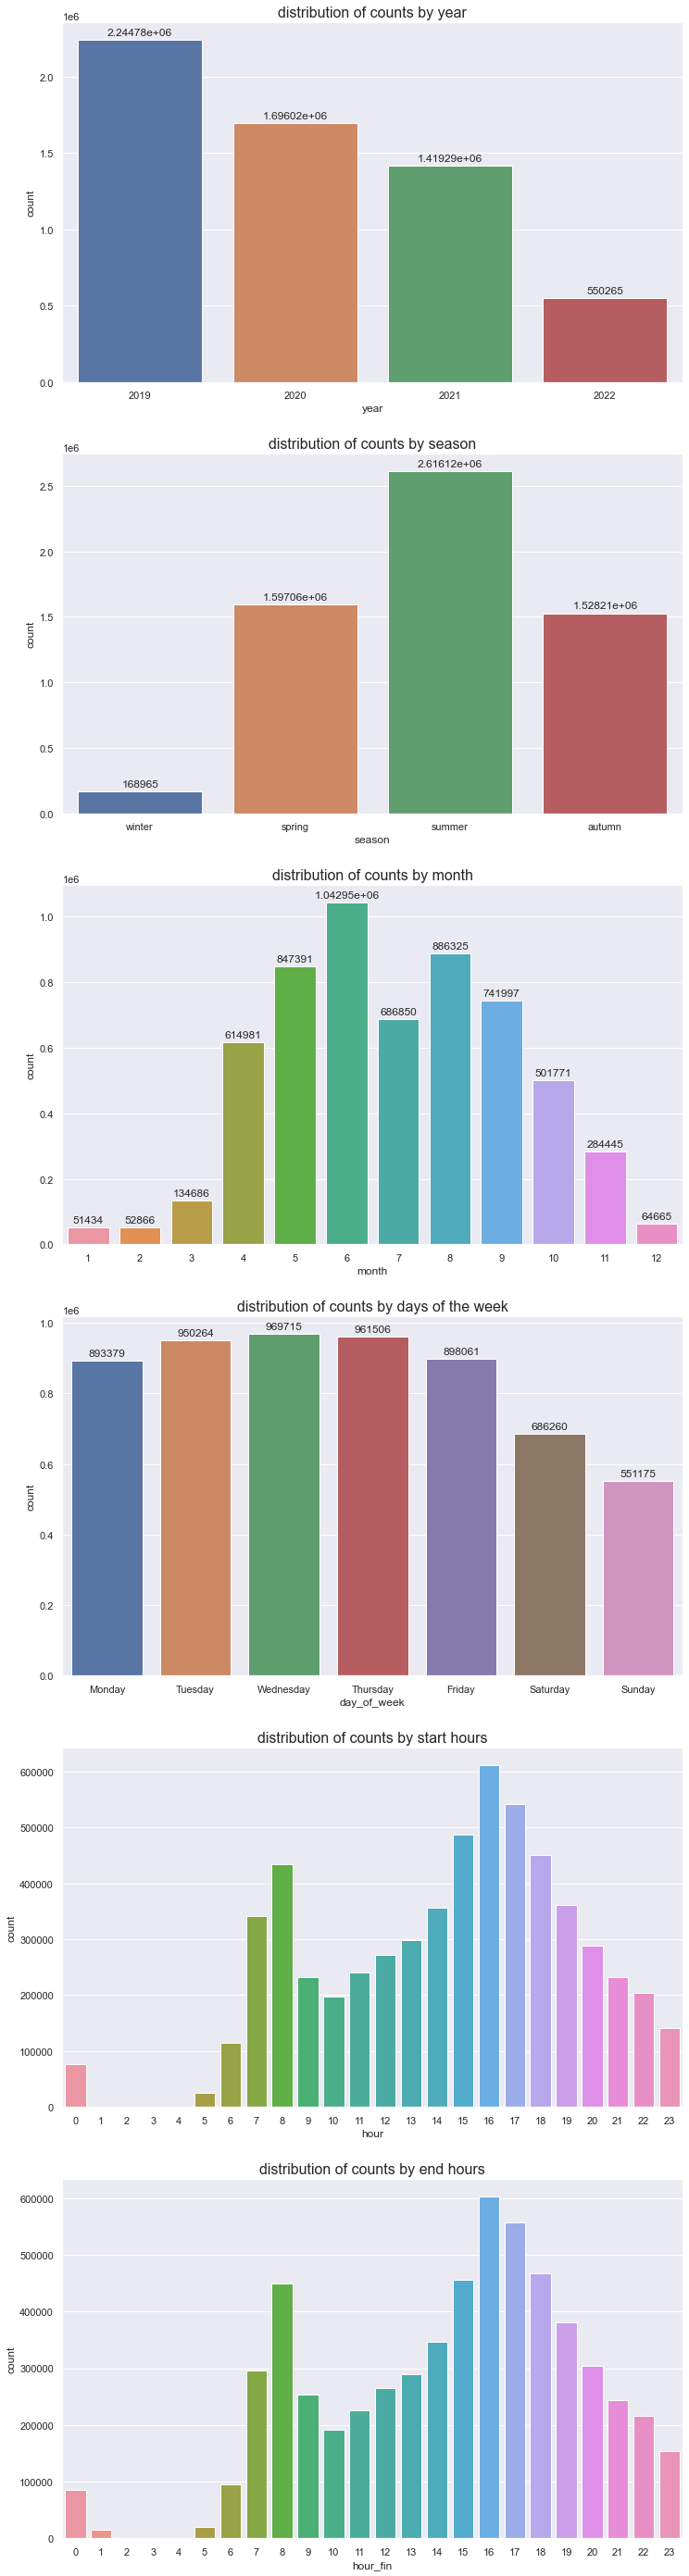

In [28]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6)
fig.set_size_inches(12, 50)

sns.countplot(x=df['year'], ax=ax1)
ax1.set_title('distribution of counts by year', fontsize = 16)
ax1.bar_label(ax1.containers[0], padding=3)

sns.countplot(x=df['season'], ax=ax2)
ax2.set_title('distribution of counts by season', fontsize = 16)
ax2.bar_label(ax2.containers[0], padding=3)

sns.countplot(x=df['month'], ax=ax3)
ax3.set_title('distribution of counts by month', fontsize = 16)
ax3.bar_label(ax3.containers[0], padding=3)

sns.countplot(x=df['day_of_week'], ax=ax4)
ax4.set_title('distribution of counts by days of the week', fontsize = 16)
ax4.bar_label(ax4.containers[0], padding=3)

sns.countplot(x=df['hour'], ax=ax5)
ax5.set_title('distribution of counts by start hours', fontsize = 16)

sns.countplot(x=df['hour_fin'], ax=ax6)
ax6.set_title('distribution of counts by end hours', fontsize = 16)


plt.show()

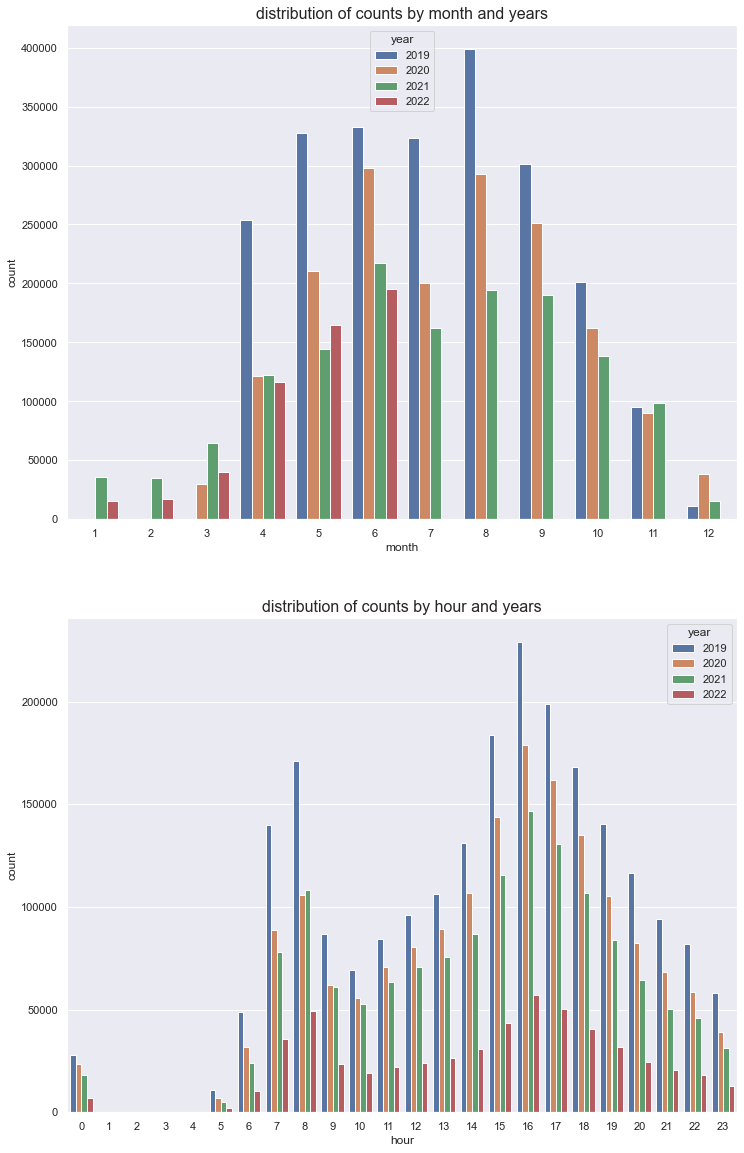

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
fig.set_size_inches(12, 20)

sns.countplot(x=df['month'], hue=df['year'], ax=ax1)
ax1.set_title('distribution of counts by month and years', fontsize = 16)
#ax1.

sns.countplot(x=df['hour'], hue=df['year'], ax=ax2)
ax2.set_title('distribution of counts by hour and years', fontsize = 16)
#ax2.set_xticks(rotation=45)

plt.show()

In [33]:
station_stats(df)


Calculating The Most Popular Stations and Trip...

The most commonly used start station is  Alexander Kiellands Plass 

The most commonly used end station is  Rådhusbrygge 4 



In [34]:
station_stats(df[(df['day_of_week'] == 'Monday')])


Calculating The Most Popular Stations and Trip...

The most commonly used start station is  Ringnes Park 

The most commonly used end station is  Rådhusbrygge 4 



In [35]:
time_stats(df)


Calculating The Most Frequent Times of Travel...

The most common year is  2019 

The most common season is  summer 

The most common month is  6 

The most common day of week  is  Wednesday 

The most common start hour is  16 

The most common finish hour is  16


In [36]:
time_stats(df[(df['start_station_id'] == 421)])


Calculating The Most Frequent Times of Travel...

The most common year is  2019 

The most common season is  summer 

The most common month is  6 

The most common day of week  is  Thursday 

The most common start hour is  17 

The most common finish hour is  17


In [37]:
time_stats(df[(df['start_station_id'] == 2347)])


Calculating The Most Frequent Times of Travel...

The most common year is  2022 

The most common season is  summer 

The most common month is  6 

The most common day of week  is  Thursday 

The most common start hour is  17 

The most common finish hour is  16


In [38]:
by_station_count_and_durationstats[(by_station_count_and_durationstats['start_station_name']== 'Huk 2') | (by_station_count_and_durationstats['start_station_name']=='Alexander Kiellands Plass')]

,start_station_name,number_of_trips,min_duration,max_duration,mean_duration,median_duration,standard_deviation_duration,variance_duration
6,Alexander Kiellands Plass,80503,61,84166,657.349453,506.0,968.834609,938640.500052
108,Huk 2,574,63,5865,1791.911150,1728.5,824.039758,679041.522633


In [39]:
station_by_month[(station_by_month['start_station_name']== 'Huk 2') | (station_by_month['start_station_name']=='Alexander Kiellands Plass')]

start_station_name  year number_of_trips               \
                                               count         mean   
21   Alexander Kiellands Plass  2019             9.0  3341.777778   
22   Alexander Kiellands Plass  2020            10.0  2370.500000   
23   Alexander Kiellands Plass  2021            12.0  1637.833333   
24   Alexander Kiellands Plass  2022             7.0  1009.714286   
408                      Huk 2  2022             2.0   287.000000   

                                                           
             std    min      25%     50%      75%     max  
21   1682.334225  174.0  2650.00  3851.0  4674.00  5146.0  
22   1279.876752  452.0  1515.00  2399.0  3475.00  4015.0  
23    996.046077  230.0   681.25  1738.0  2302.25  3049.0  
24    979.410148    1.0   243.50   589.0  1789.00  2413.0  
408   403.050865    2.0   144.50   287.0   429.50   572.0

In [40]:
station_by_season[(station_by_season['start_station_name']== 'Huk 2') | (station_by_season['start_station_name']=='Alexander Kiellands Plass')]

start_station_name  year number_of_trips                        \
                                               count     mean          std   
24   Alexander Kiellands Plass  2019             4.0  7519.00  5593.955607   
25   Alexander Kiellands Plass  2020             4.0  5926.25  3988.648173   
26   Alexander Kiellands Plass  2021             4.0  4913.50  2880.981372   
27   Alexander Kiellands Plass  2022             4.0  1767.00  1909.563475   
432                      Huk 2  2019             4.0     0.00     0.000000   
433                      Huk 2  2020             4.0     0.00     0.000000   
434                      Huk 2  2021             4.0     0.00     0.000000   
435                      Huk 2  2022             4.0   143.50   287.000000   

                                                
        min      25%     50%      75%      max  
24    174.0  5956.50  8057.5  9620.00  13787.0  
25    561.0  4516.50  6533.5  7943.25  10077.0  
26   1155.0  3653.25  5268.0  6528.25   7963.0  
27      0.0   365.25  1450.5  2852.25   4167.0  
432     0.0     0.00     0.0     0.00      0.0  
433     0.0     0.00     0.0     0.00      0.0  
434     0.0     0.00     0.0     0.00      0.0  
435     0.0     0.00     0.0   143.50    574.0

## -------------------------------------------------------------------------------------------------------- 


## Завдання 5 ##

### Prediction for a 4 days for all stations

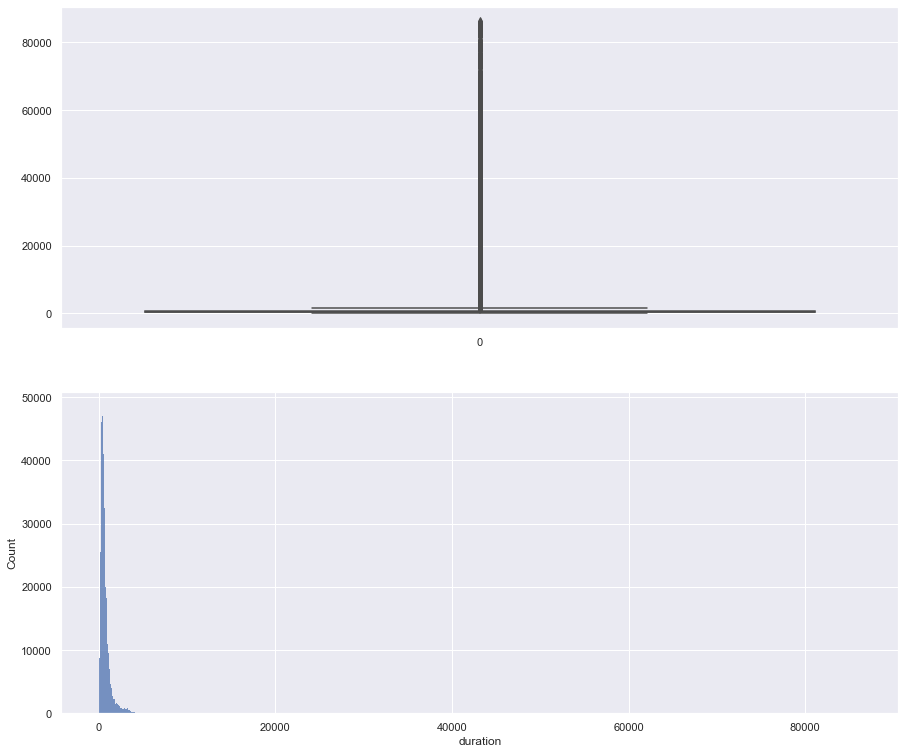

In [65]:
fig,(ax1,ax2) = plt.subplots(nrows=2)
fig.set_size_inches(15, 13)

sns.boxplot(data = df['duration'], ax=ax1)
sns.histplot(data = df['duration'], ax=ax2)

plt.show()

In [66]:
upper_limit = df['duration'].quantile(0.99)

print('Upper limit -', upper_limit)

Upper limit - 3634.0


In [67]:
new_df = df[(df['duration'] <= upper_limit)]

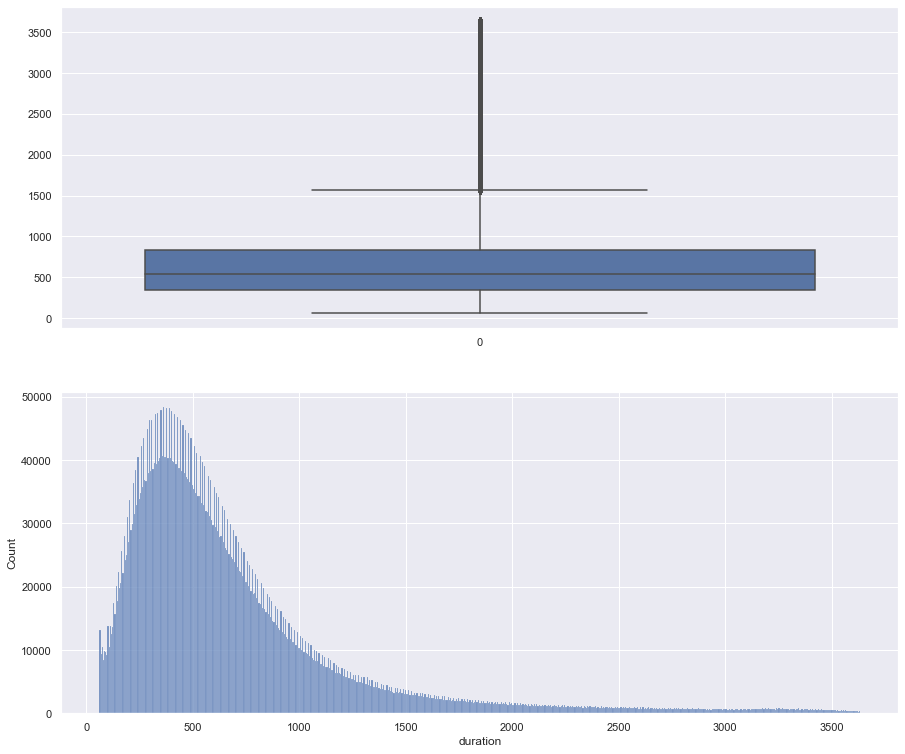

(5910360, 22)


In [68]:
fig,(ax1,ax2) = plt.subplots(nrows=2)
fig.set_size_inches(15, 13)

sns.boxplot(data = new_df['duration'], ax=ax1)
sns.histplot(data = new_df['duration'], ax=ax2)

plt.show()
print(df.shape)

In [69]:
by_date = new_df[['date', 'for_count' ]].groupby('date').count().reset_index()
by_date['date'] = pd.to_datetime(by_date['date'])
print(by_date.info())
print('-'  * 50)
print('Зразок даних')
print(by_date.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1086 non-null   datetime64[ns]
 1   for_count  1086 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 17.1 KB
None
--------------------------------------------------
Зразок даних
        date  for_count
0 2019-04-03       4957
1 2019-04-04       7918
2 2019-04-05       7507
3 2019-04-06       6754
4 2019-04-07       5041


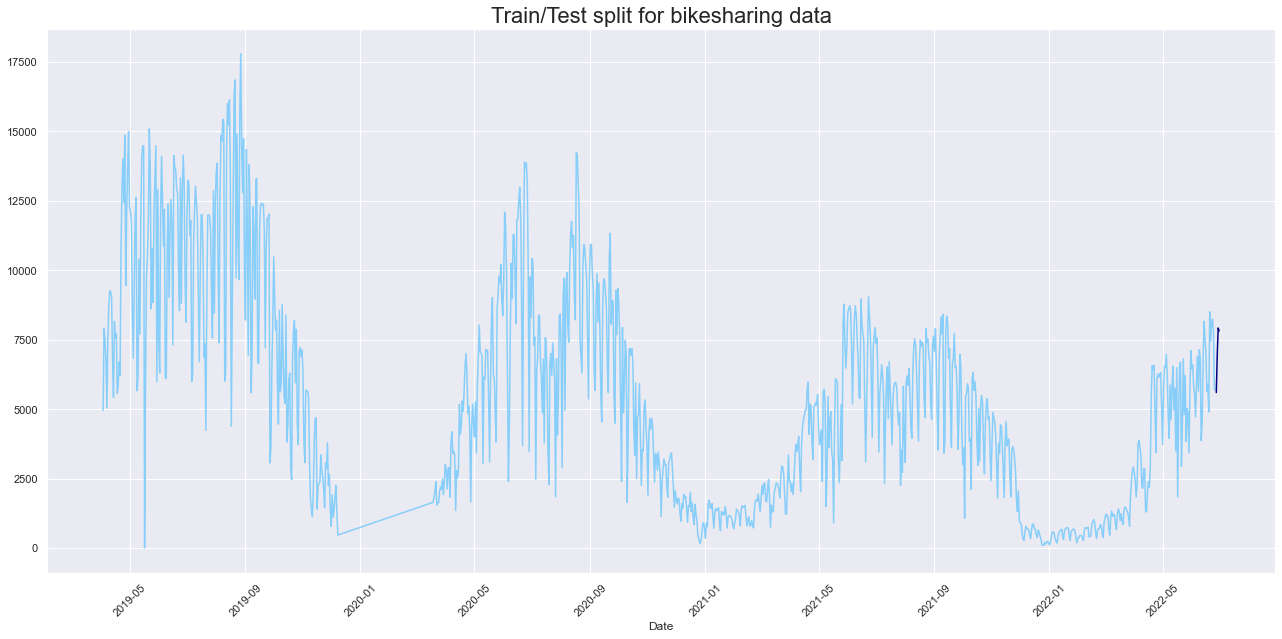

In [70]:
df_test = by_date.loc[(by_date['date'] > "2022-06-26") & (by_date['date'] < "2022-07-01")]
df_train = by_date.loc[by_date['date'] < "2022-06-26"]
df_test.set_index('date', inplace=True)

plt.subplots(figsize=(22, 10))

plt.plot(df_train.set_index('date'), color = "lightskyblue")
plt.plot(df_test, color = "navy")
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for bikesharing data", fontsize = 22)
plt.show()

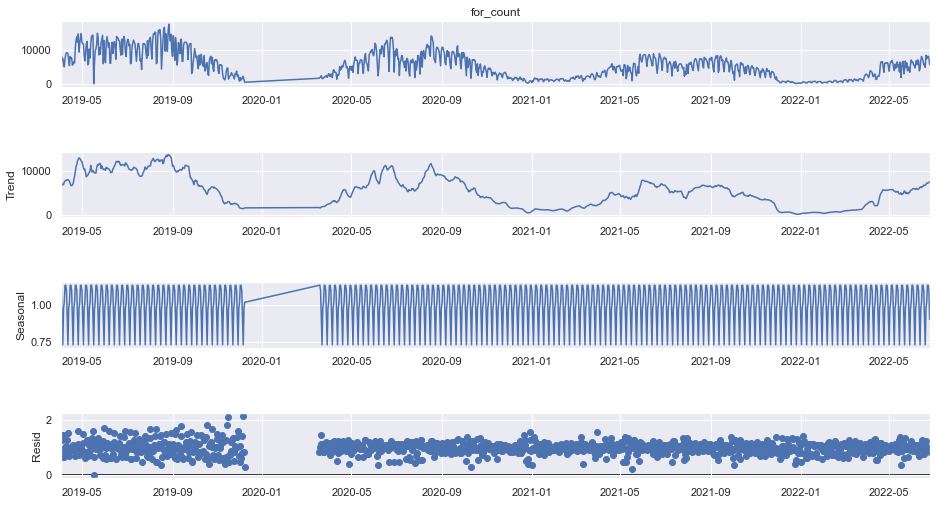

In [47]:
sd_mul = seasonal_decompose(df_train.set_index("date")["for_count"],                         
                        period=7,
                        model='mul', 
                        extrapolate_trend='freq')


fig = sd_mul.plot()
fig.set_size_inches(15,8)
plt.show()

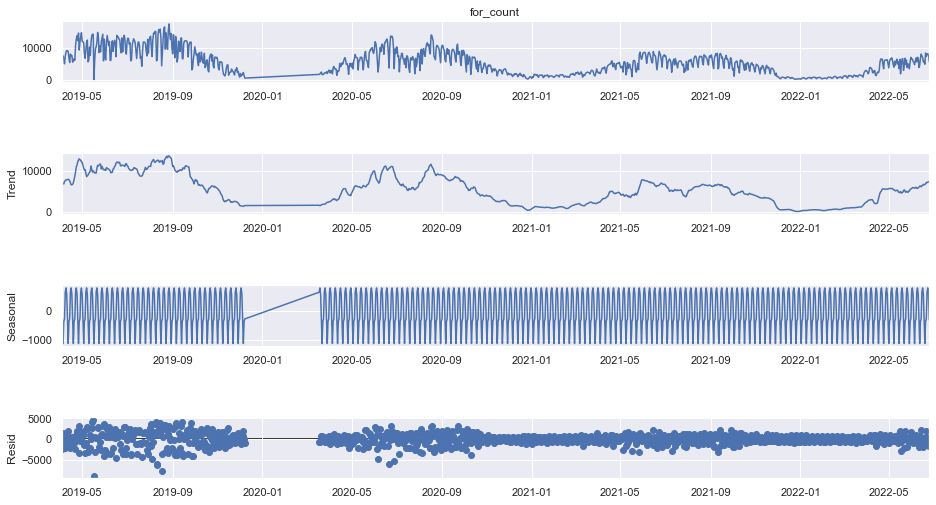

In [48]:
sd_add = seasonal_decompose(df_train.set_index("date")["for_count"],                         
                        period=7,
                        model='add', 
                        extrapolate_trend='freq')
fig = sd_add.plot()
fig.set_size_inches(15,8)
plt.show()

/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


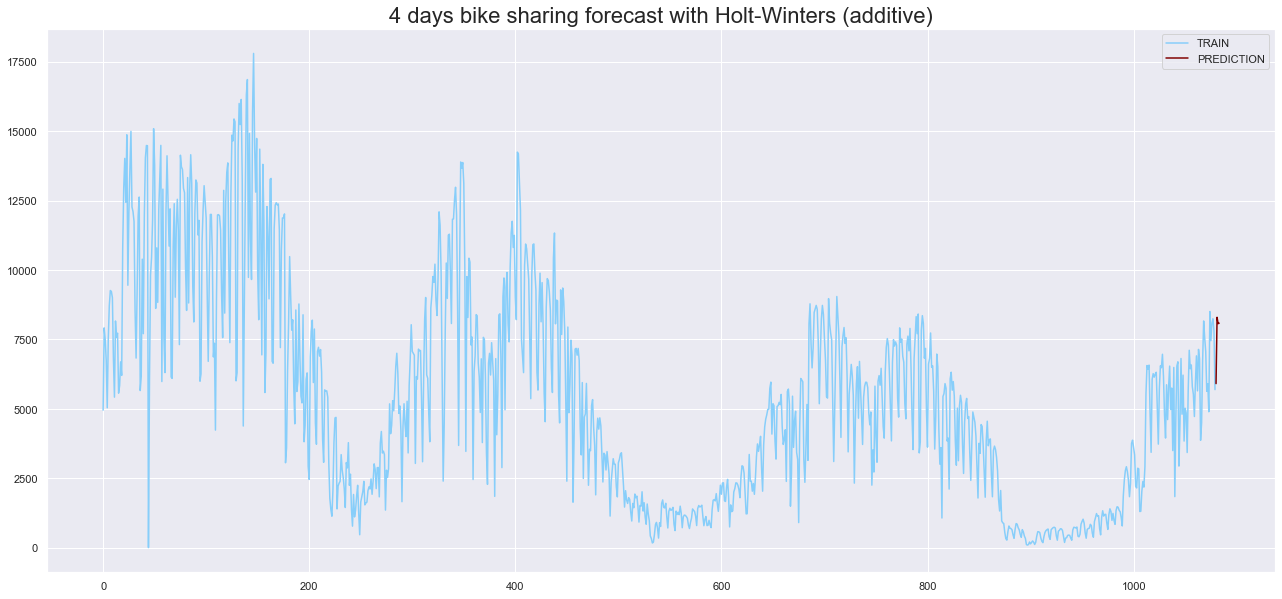

In [49]:
fitted_model = ExponentialSmoothing(df_train.set_index('date')['for_count'],
                                    trend='add',seasonal='add',seasonal_periods=7).fit()


test_predictions_add = fitted_model.forecast(len(df_test))

plt.figure(figsize = (22,10))
plt.title('4 days bike sharing forecast with Holt-Winters (additive)', fontsize = 22)

past = plt.plot(df_train.index, df_train['for_count'], 'lightskyblue', label='TRAIN')
predicted_future = plt.plot(test_predictions_add.index, test_predictions_add, 'maroon', label='PREDICTION')


plt.legend()
plt.show()


/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


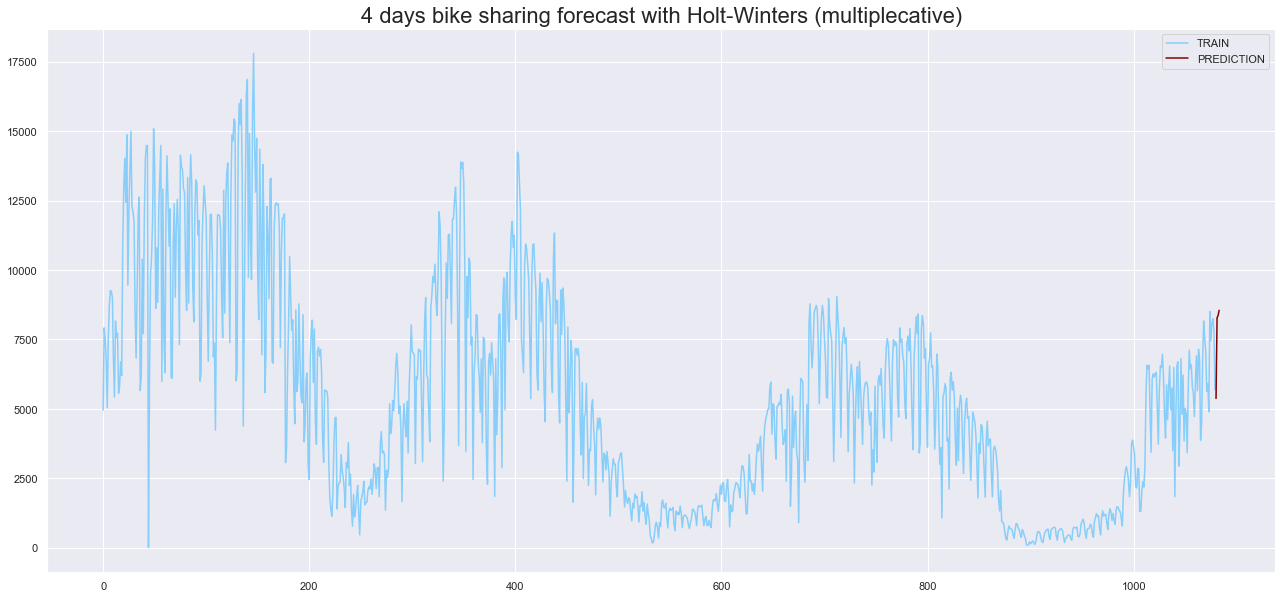

In [50]:
fitted_model = ExponentialSmoothing(df_train.set_index('date')['for_count'],
                                    trend='mul',seasonal='mul',seasonal_periods=7).fit()


test_predictions_mul = fitted_model.forecast(len(df_test))

plt.figure(figsize = (22,10))
plt.title('4 days bike sharing forecast with Holt-Winters (multiplecative)', fontsize = 22)

past = plt.plot(df_train.index, df_train['for_count'], 'lightskyblue', label='TRAIN')
predicted_future = plt.plot(test_predictions_mul.index, test_predictions_mul, 'maroon', label='PREDICTION')


plt.legend()
plt.show()

In [51]:
print('additive')
print('Mean Absolute Error =', mean_absolute_error(df_test, test_predictions_add))
print('Mean Squared Error =', mean_squared_error(df_test, test_predictions_add))
print('Mean absolute percentage Error =', mean_absolute_percentage_error(df_test, test_predictions_add)*100)

print('-' * 50)
print('multiplecative')
print('Mean Absolute Error =', mean_absolute_error(df_test, test_predictions_mul))
print('Mean Squared Error =', mean_squared_error(df_test, test_predictions_mul))
print('Mean absolute percentage Error =', mean_absolute_percentage_error(df_test, test_predictions_mul)*100)

additive
Mean Absolute Error = 521.6479976417359
Mean Squared Error = 510904.7052834604
Mean absolute percentage Error = 7.6125888060538704
--------------------------------------------------
multiplecative
Mean Absolute Error = 684.6442046464304
Mean Squared Error = 646456.812243044
Mean absolute percentage Error = 9.564530530184905


----------

### Prediction by hours for all stations

In [72]:
df['hour'] = pd.to_datetime(df['hour'], format='%H').dt.time
df['date_hour'] = df['date'].astype(str) + " " +df['hour'].astype(str)
df['date_hour'] =pd.to_datetime(df['date_hour'])

ValueError: unconverted data remains: :00:00

In [73]:
new_df_hour = df[(df['started_at_dt'] >= '2022-01-03') & (df['duration'] <= upper_limit)]

In [74]:
by_date = new_df_hour[['date_hour', 'for_count' ]].groupby('date_hour').count().reset_index()
#by_date['date_hour'] = pd.to_datetime(by_date['date_hour'])
print(by_date.info())
print('-'  * 50)
print('Зразок даних')
print(by_date.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3589 entries, 0 to 3588
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_hour  3589 non-null   datetime64[ns]
 1   for_count  3589 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 56.2 KB
None
--------------------------------------------------
Зразок даних
            date_hour  for_count
0 2022-01-03 00:00:00          1
1 2022-01-03 05:00:00          4
2 2022-01-03 06:00:00         14
3 2022-01-03 07:00:00         27
4 2022-01-03 08:00:00         38


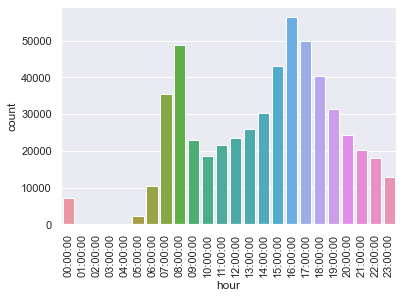

In [75]:
fig.set_size_inches(24, 15)
sns.countplot(x=new_df_hour['hour'].sort_values())
plt.xticks(rotation=90) 

plt.show()

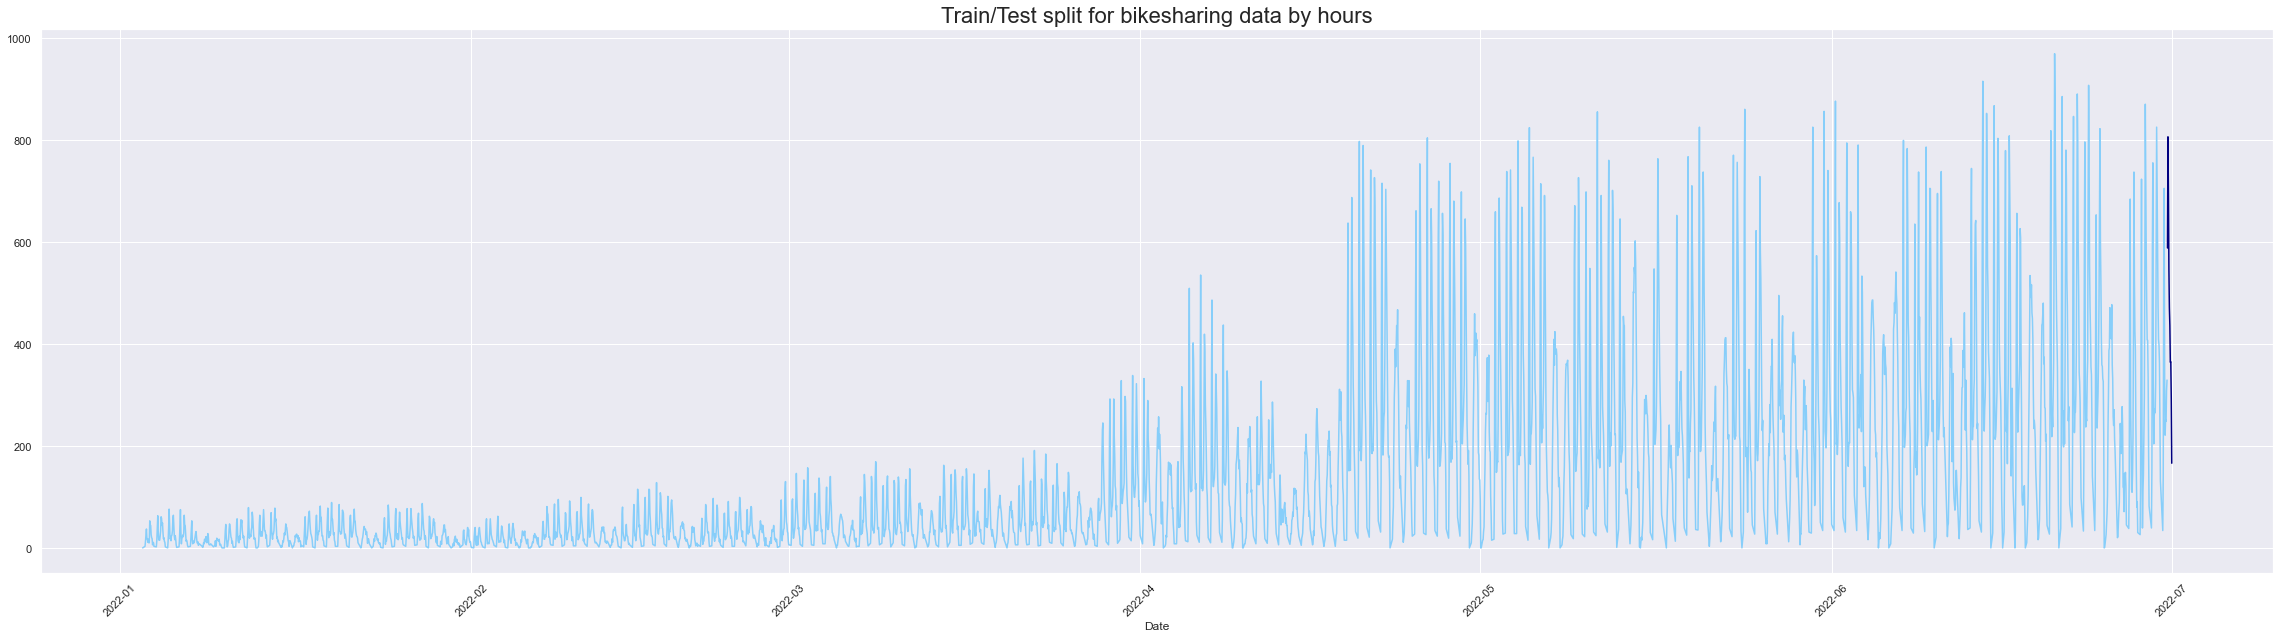

In [76]:
df_train = by_date.iloc[:(len(by_date['date_hour'])-10)]
df_test = by_date.loc[(len(by_date['date_hour'])-10):]
df_test.set_index('date_hour', inplace=True)

plt.subplots(figsize=(40, 10))

plt.plot(df_train.set_index('date_hour'), color = "lightskyblue")
plt.plot(df_test, color = "navy")
#plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for bikesharing data by hours", fontsize = 22)
plt.show()

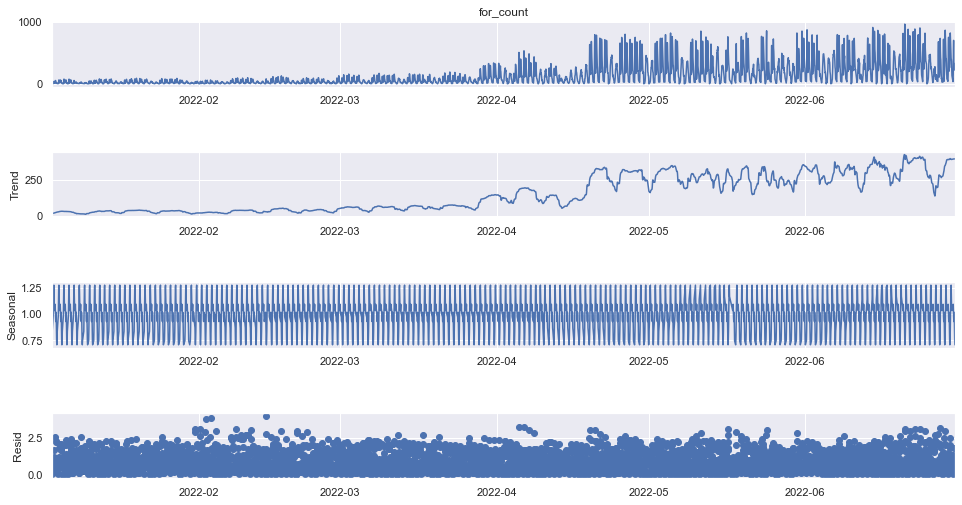

In [77]:
sd_mul_hour = seasonal_decompose(df_train.set_index("date_hour")["for_count"],                         
                        period=20,
                        model='mul', 
                        extrapolate_trend='freq')


fig = sd_mul_hour.plot()
fig.set_size_inches(15,8)
plt.show()

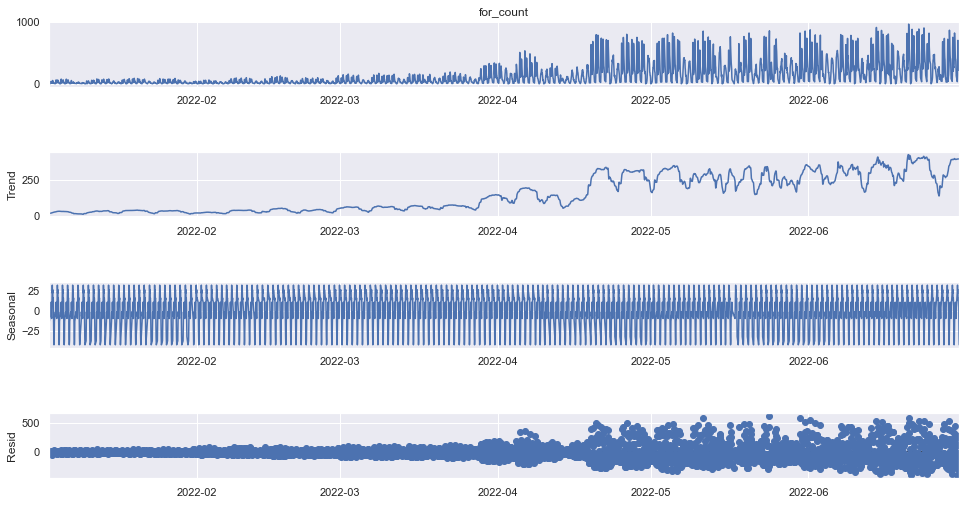

In [78]:
sd_add_hour = seasonal_decompose(df_train.set_index("date_hour")["for_count"],                         
                        period=20,
                        model='add', 
                        extrapolate_trend='freq')


fig = sd_add_hour.plot()
fig.set_size_inches(15,8)
plt.show()

/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


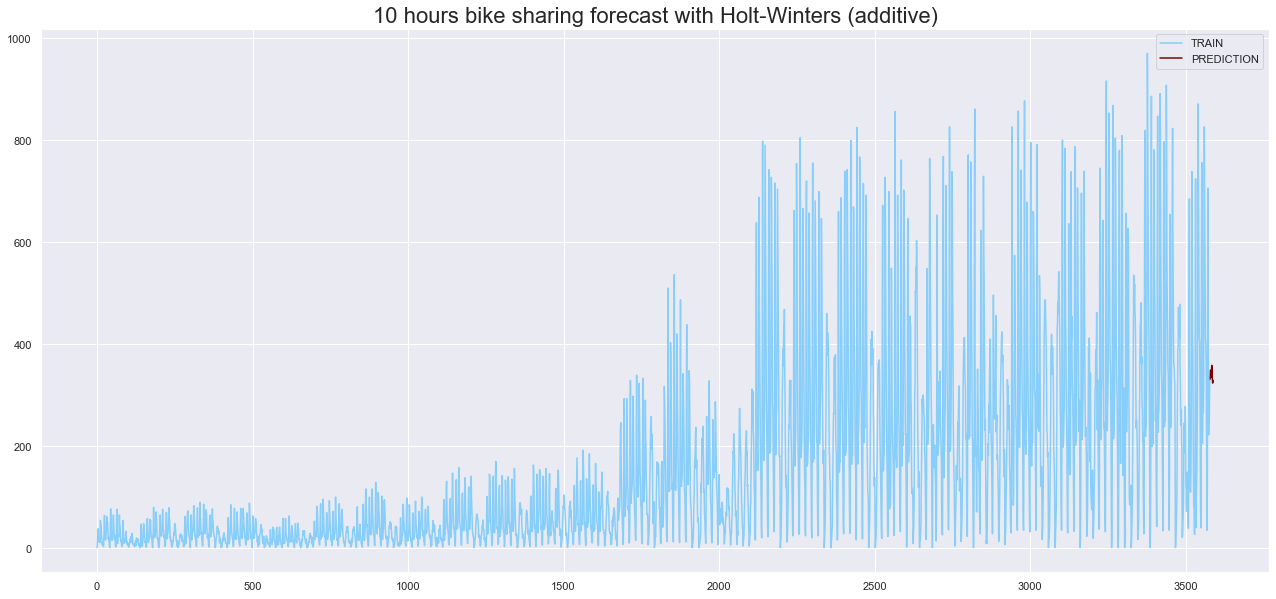

In [80]:
fitted_model = ExponentialSmoothing(df_train.set_index('date_hour')['for_count'],
                                    trend='add',seasonal='add',seasonal_periods=20).fit()


test_predictions_add_hour = fitted_model.forecast(len(df_test))

plt.figure(figsize = (22,10))
plt.title('10 hours bike sharing forecast with Holt-Winters (additive)', fontsize = 22)

past = plt.plot(df_train.index, df_train['for_count'], 'lightskyblue', label='TRAIN')
predicted_future = plt.plot(test_predictions_add_hour.index, test_predictions_add_hour, 'maroon', label='PREDICTION')


plt.legend()
plt.show()

/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available

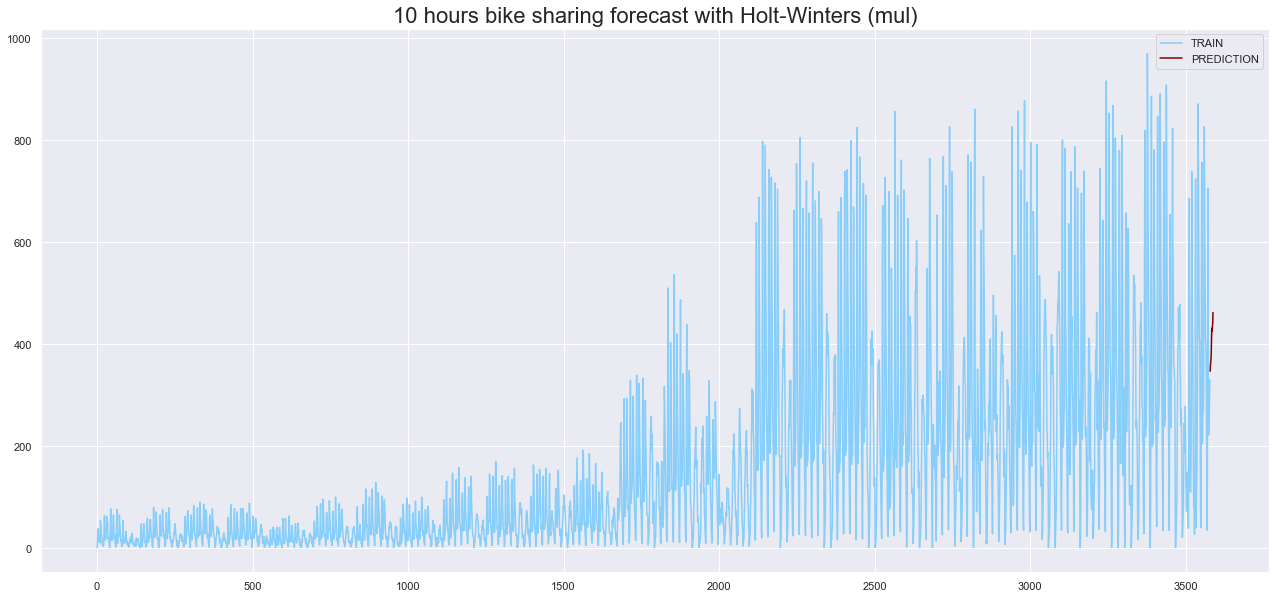

In [81]:
fitted_model = ExponentialSmoothing(df_train.set_index('date_hour')['for_count'],
                                    trend='mul',seasonal='add',seasonal_periods=20).fit()


test_predictions_mul_hour = fitted_model.forecast(len(df_test))

plt.figure(figsize = (22,10))
plt.title('10 hours bike sharing forecast with Holt-Winters (mul)', fontsize = 22)

past = plt.plot(df_train.index, df_train['for_count'], 'lightskyblue', label='TRAIN')
predicted_future = plt.plot(test_predictions_mul_hour.index, test_predictions_mul_hour, 'maroon', label='PREDICTION')


plt.legend()
plt.show()

In [82]:
print('additive')
print('Mean Absolute Error =', mean_absolute_error(df_test, test_predictions_add_hour))
print('Mean Squared Error =', mean_squared_error(df_test, test_predictions_add_hour))
print('Mean absolute percentage Error =', mean_absolute_percentage_error(df_test, test_predictions_add_hour)*100)

print('-' * 50)
print('multiplecative')
print('Mean Absolute Error =', mean_absolute_error(df_test, test_predictions_mul_hour))
print('Mean Squared Error =', mean_squared_error(df_test, test_predictions_mul_hour))
print('Mean absolute percentage Error =', mean_absolute_percentage_error(df_test, test_predictions_mul_hour)*100)

additive
Mean Absolute Error = 173.10693258728475
Mean Squared Error = 49295.63145775298
Mean absolute percentage Error = 35.726235951465306
--------------------------------------------------
multiplecative
Mean Absolute Error = 183.13524326101793
Mean Squared Error = 51608.90298763195
Mean absolute percentage Error = 45.21717533228705


## -----------------------------------------------------------------------------------------------------------

### Prediction for a 4 days for Alexander Kiellands Plass

In [83]:
df_AKP = df.loc[(df['start_station_id'] == 421)]

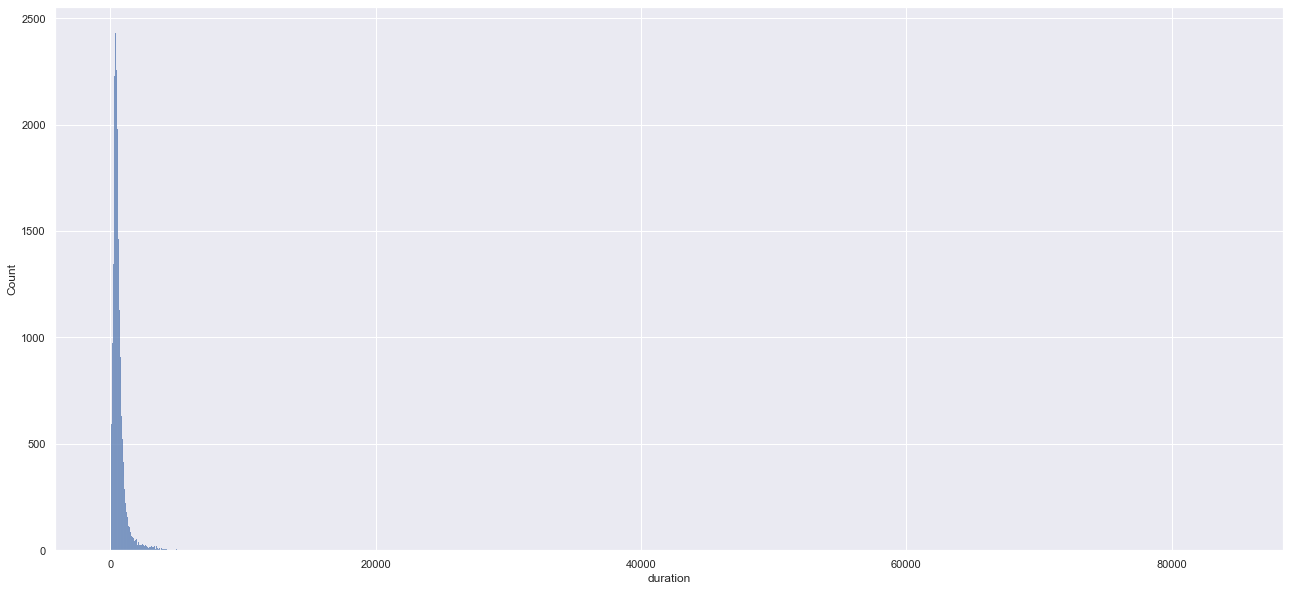

(80503, 22)


In [84]:
plt.figure(figsize = (22,10))

sns.histplot(data = df_AKP['duration'])

plt.show()
print(df_AKP.shape)

In [85]:
upper_limit = df_AKP['duration'].quantile(0.99)

print('Upper limit -', upper_limit)

Upper limit - 3282.979999999996


In [86]:
df_AKP = df_AKP[(df_AKP['duration'] <= upper_limit)]

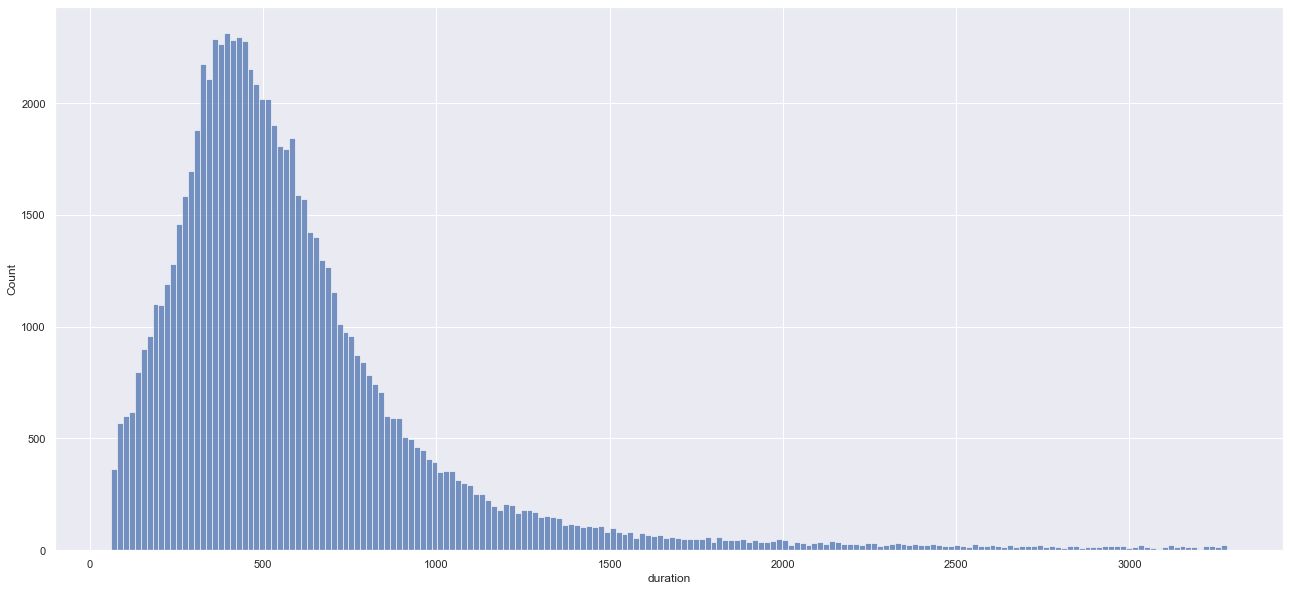

(79697, 22)


In [87]:
plt.figure(figsize = (22,10))

sns.histplot(data = df_AKP['duration'])

plt.show()
print(df_AKP.shape)

In [88]:
by_date_AKP = df_AKP[['date', 'for_count' ]].groupby('date').count().reset_index()
by_date_AKP['date'] = pd.to_datetime(by_date_AKP['date'])
print(by_date_AKP.info())
print('-'  * 50)
print('Зразок даних')
print(by_date_AKP.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1084 non-null   datetime64[ns]
 1   for_count  1084 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 17.1 KB
None
--------------------------------------------------
Зразок даних
        date  for_count
0 2019-04-03         81
1 2019-04-04        131
2 2019-04-05        113
3 2019-04-06        125
4 2019-04-07         71


In [89]:
df_test = by_date_AKP.loc[(by_date_AKP['date'] > "2022-06-26") & (by_date_AKP['date'] < "2022-07-01")]
df_train = by_date_AKP.loc[by_date_AKP['date'] < "2022-06-26"]
df_test.set_index('date', inplace=True)

/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


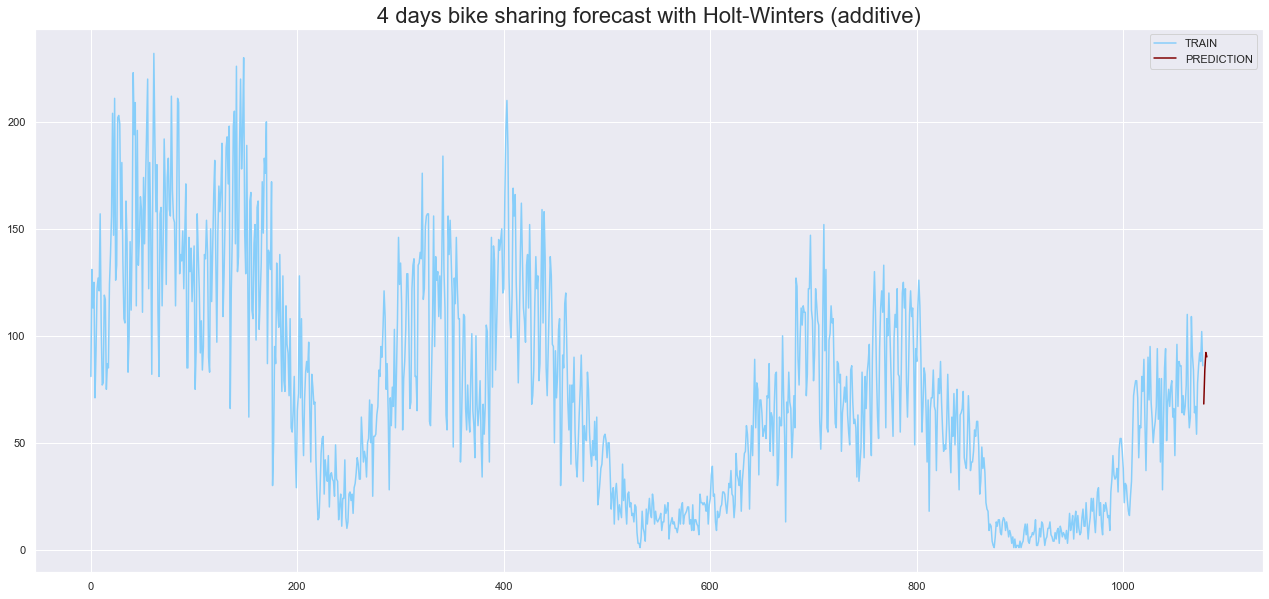

In [90]:
fitted_model = ExponentialSmoothing(df_train.set_index('date')['for_count'],
                                    trend='add',seasonal='add',seasonal_periods=7).fit()


test_predictions_add = fitted_model.forecast(len(df_test))

plt.figure(figsize = (22,10))
plt.title('4 days bike sharing forecast with Holt-Winters (additive)', fontsize = 22)

past = plt.plot(df_train.index, df_train['for_count'], 'lightskyblue', label='TRAIN')
predicted_future = plt.plot(test_predictions_add.index, test_predictions_add, 'maroon', label='PREDICTION')


plt.legend()
plt.show()

/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/chedmurray/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


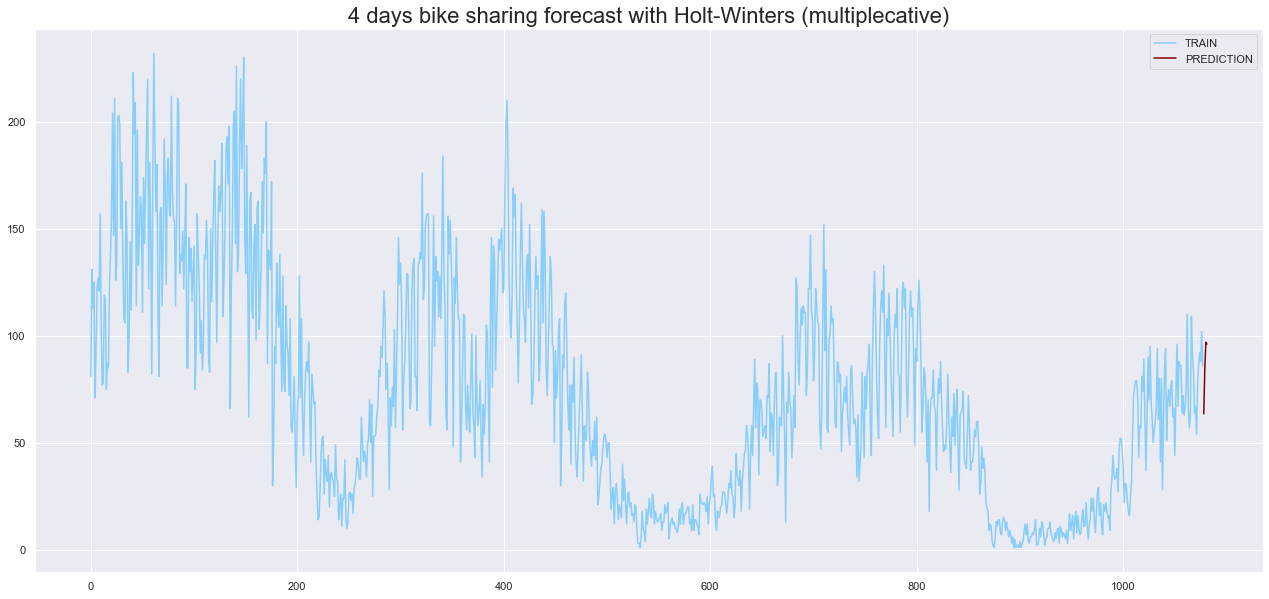

In [91]:
fitted_model = ExponentialSmoothing(df_train.set_index('date')['for_count'],
                                    trend='mul',seasonal='mul',seasonal_periods=7).fit()


test_predictions_mul = fitted_model.forecast(len(df_test))

plt.figure(figsize = (22,10))
plt.title('4 days bike sharing forecast with Holt-Winters (multiplecative)', fontsize = 22)

past = plt.plot(df_train.index, df_train['for_count'], 'lightskyblue', label='TRAIN')
predicted_future = plt.plot(test_predictions_mul.index, test_predictions_mul, 'maroon', label='PREDICTION')


plt.legend()
plt.show()

In [92]:
print('additive')
print('Mean Absolute Error =', mean_absolute_error(df_test, test_predictions_add))
print('Mean Squared Error =', mean_squared_error(df_test, test_predictions_add))
print('Mean absolute percentage Error =', mean_absolute_percentage_error(df_test, test_predictions_add)*100)

print('-' * 50)
print('multiplecative')
print('Mean Absolute Error =', mean_absolute_error(df_test, test_predictions_mul))
print('Mean Squared Error =', mean_squared_error(df_test, test_predictions_mul))
print('Mean absolute percentage Error =', mean_absolute_percentage_error(df_test, test_predictions_mul)*100) 

additive
Mean Absolute Error = 15.687477265752069
Mean Squared Error = 367.68153713871243
Mean absolute percentage Error = 14.950397883646415
--------------------------------------------------
multiplecative
Mean Absolute Error = 11.66821170626726
Mean Squared Error = 226.49456514829905
Mean absolute percentage Error = 10.577406709605617


In [93]:
test_predictions_mul

1078    63.550466
1079    84.760359
1080    97.006125
1081    96.111136
dtype: float64

In [94]:
test_predictions_add

1078    68.129219
1079    84.033686
1080    92.198411
1081    90.147212
dtype: float64

In [95]:
df_test

,for_count
date,
2022-06-27,61
2022-06-28,87
2022-06-29,115
2022-06-30,120
